# Deliverable 3 - Captioning

## Import

In [1]:
# Disable Tensorflow's warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pickle

## Load COCO Dataset

In [3]:
annotation_file = 'data/3_annotations/captions_train2014.json'
image_folder = 'data/3_train2014/'

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = image_folder + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)


In [6]:
# Select the first 50000 image_paths from the shuffled set.
train_image_paths = image_paths[:50000]

<start> Commuter train traveling near rocky beach in rural area. <end>


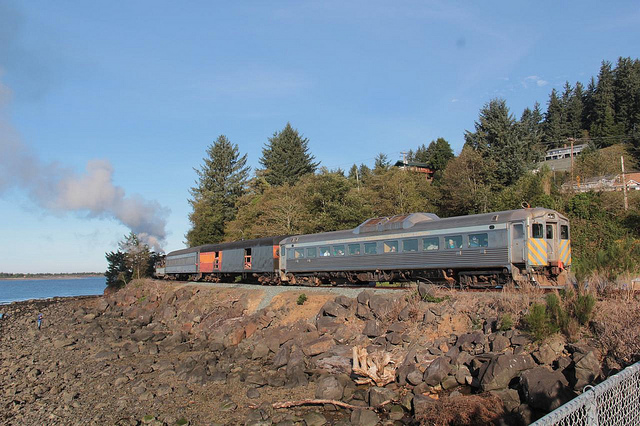

In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

## Load InceptionV3 model

In [8]:
# Load CNN part of the Inception model 
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

# Take Input layer of Inception                                                
new_input = image_model.input
# Take Output layer of Inception (last CNN layer)   
hidden_layer = image_model.layers[-1].output

# Create a model that will create image vector for the RNN
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Preprocessing Images with InceptionV3

In [9]:
# Convert images at format expected by InceptionV3 (image 299px by 299px, and pixels between -1 and 1)
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [10]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Convert image set to Dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Preprocess each image with InceptionV3 and cache it
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# Save preprocessed images
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocessing and tokenize subtitles

In [11]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# Standardize captions (lowercase, clean odd characters)
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max number of word for a caption.
max_length = 8
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [12]:
# Save train captions for the pipeline
with open('data/3_train_captions', 'wb') as outp:  # Overwrites any existing file.
      pickle.dump(train_captions, outp, pickle.HIGHEST_PROTOCOL)

## Create training and validation sets

In [13]:
# Create vector with image and captions
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

# Train set
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

# Validation set
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

## Create Dataset and Batches

In [14]:
# Settings some parameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [15]:
# Load preprocessed images
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [16]:
# Create final dataset
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

In [17]:
# Attention class definition

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [18]:
# CNN Encoder definition

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.embedding_dim = embedding_dim
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
    def get_config(self):
      return {"embedding_dim": self.embedding_dim}

    @classmethod
    def from_config(cls, config):
      return cls(**config)


In [19]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(self.vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def _reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

  def get_config(self):
    return {"embedding_dim": self.embedding_dim,"units": self.units,"embedding_dim": self.embedding_dim}

  @classmethod
  def from_config(cls, config):
      return cls(**config)

  @tf.function
  def reset_state(self, batch_size):
      """ tf.function-deocrated version of _reset_state """
      return self._reset_state(batch_size)

In [20]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [27]:
checkpoint_path = "./checkpoints/3_captioning_train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Train

In [29]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [30]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [31]:
EPOCHS = 100
max_length = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.2587
Epoch 1 Batch 100 Loss 3.3726
Epoch 1 Batch 200 Loss 2.9422
Epoch 1 Batch 300 Loss 2.8642
Epoch 1 Batch 400 Loss 3.3246
Epoch 1 Batch 500 Loss 3.0065
Epoch 1 Batch 600 Loss 2.8840
Epoch 1 Batch 700 Loss 3.1741
Epoch 1 Batch 800 Loss 3.0923
Epoch 1 Batch 900 Loss 3.0430
Epoch 1 Batch 1000 Loss 2.8592
Epoch 1 Batch 1100 Loss 2.9062
Epoch 1 Batch 1200 Loss 2.7746
Epoch 1 Batch 1300 Loss 2.9485
Epoch 1 Batch 1400 Loss 2.9419
Epoch 1 Batch 1500 Loss 2.6815
Epoch 1 Batch 1600 Loss 2.8487
Epoch 1 Batch 1700 Loss 2.6562
Epoch 1 Batch 1800 Loss 2.6607
Epoch 1 Batch 1900 Loss 2.6088
Epoch 1 Batch 2000 Loss 2.6905
Epoch 1 Batch 2100 Loss 2.7506
Epoch 1 Batch 2200 Loss 2.9289
Epoch 1 Batch 2300 Loss 2.8018
Epoch 1 Batch 2400 Loss 2.8886
Epoch 1 Batch 2500 Loss 2.8807
Epoch 1 Batch 2600 Loss 2.6461
Epoch 1 Batch 2700 Loss 2.6159
Epoch 1 Batch 2800 Loss 2.6055
Epoch 1 Batch 2900 Loss 2.7603
Epoch 1 Batch 3000 Loss 2.7305
Epoch 1 Batch 3100 Loss 2.5205
Epoch 1 Loss 2.84080

## Graphs

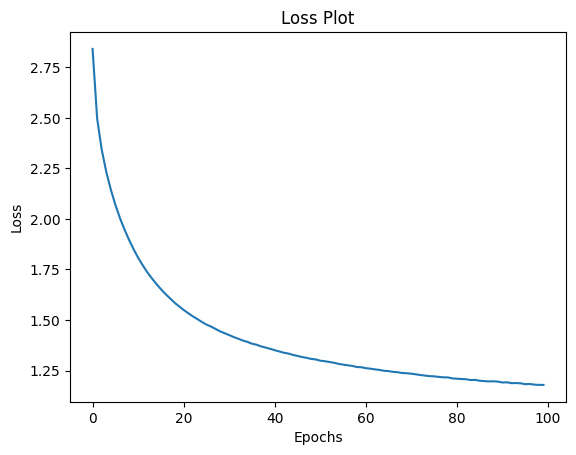

In [32]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluate

In [33]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [34]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a [UNK] black and white cat standing
Prediction Caption: a small dog in a


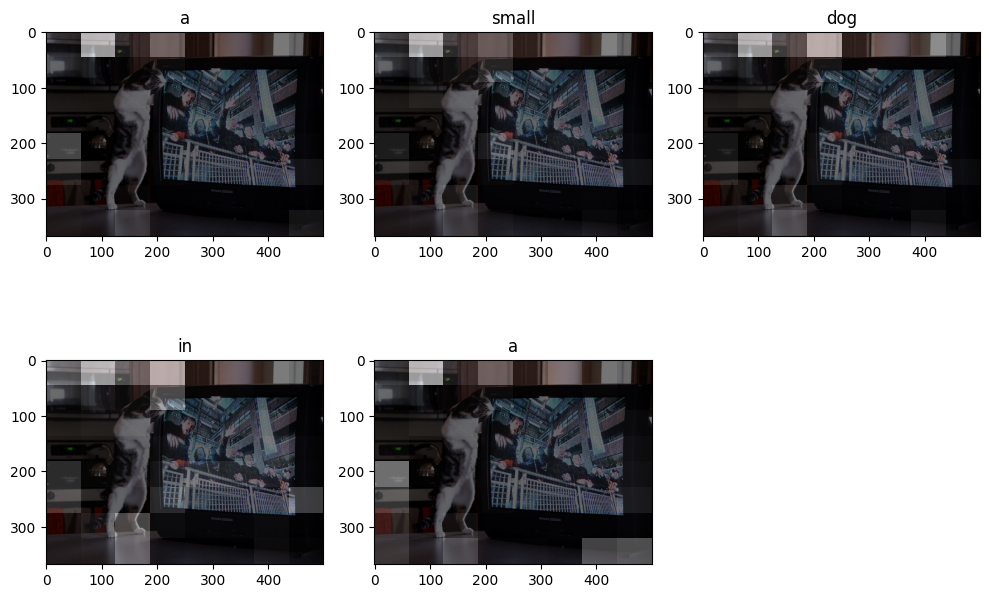

In [35]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Save Models

In [36]:
import datetime
import pandas as pd

date:datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir:str = f"models/cap_encoder_{date}"
encoder.save(model_dir)
date:datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir:str = f"models/cap_decoder_{date}"
decoder.save(model_dir)

INFO:tensorflow:Assets written to: models/cap_encoder_10.21.2022_05:04:22/assets


INFO:tensorflow:Assets written to: models/cap_decoder_10.21.2022_05:04:24/assets


INFO:tensorflow:Assets written to: models/cap_decoder_10.21.2022_05:04:24/assets


## Try on unkown images

In [39]:
max_length = 6

Prediction Caption: two women sitting on a bench


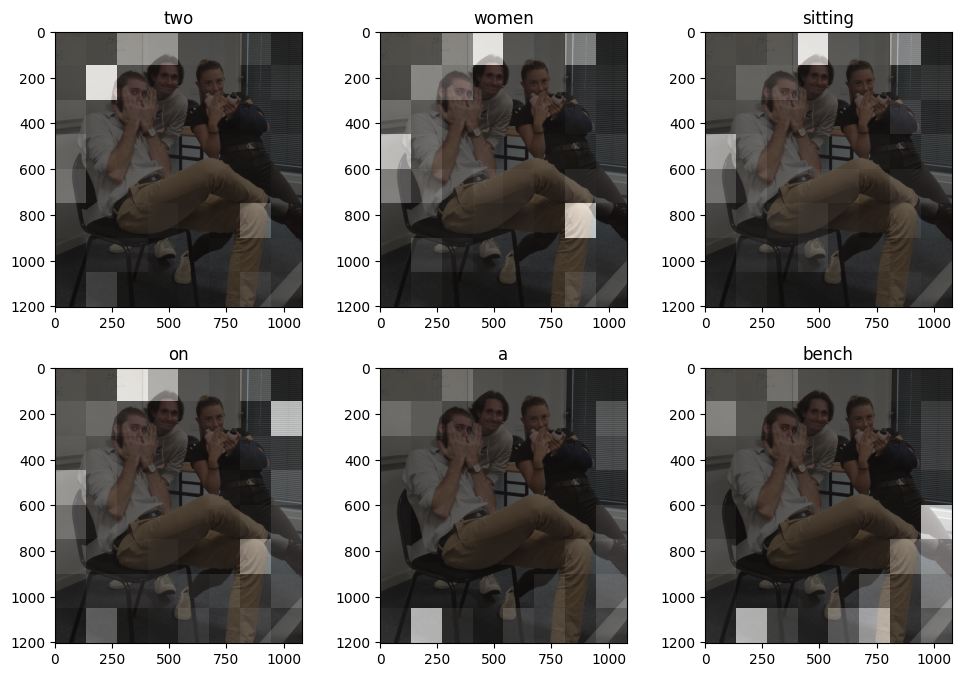

Prediction Caption: bushes is nest to the mat


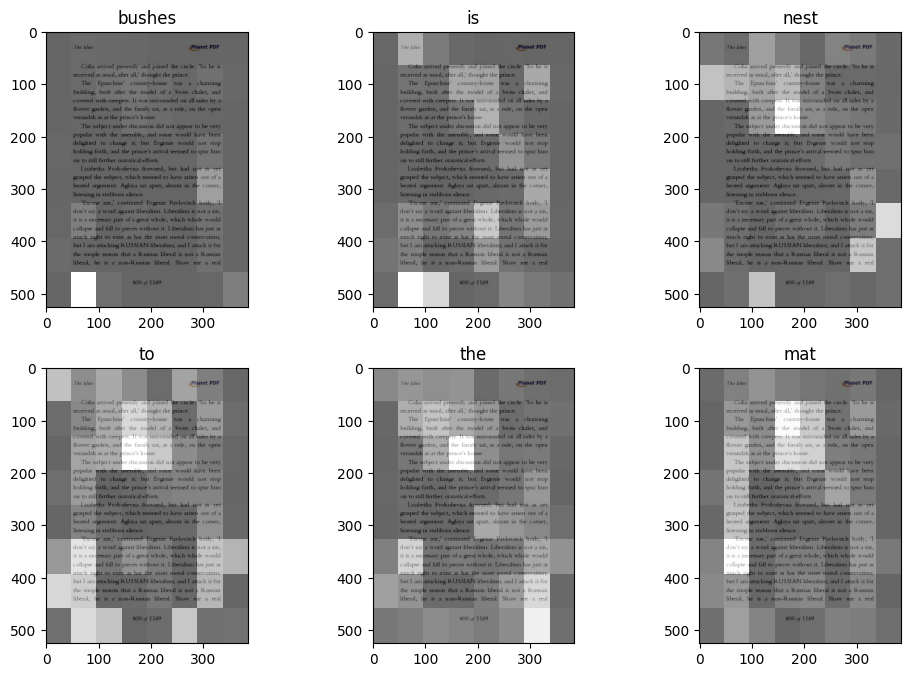

Prediction Caption: a man is posing wearing a


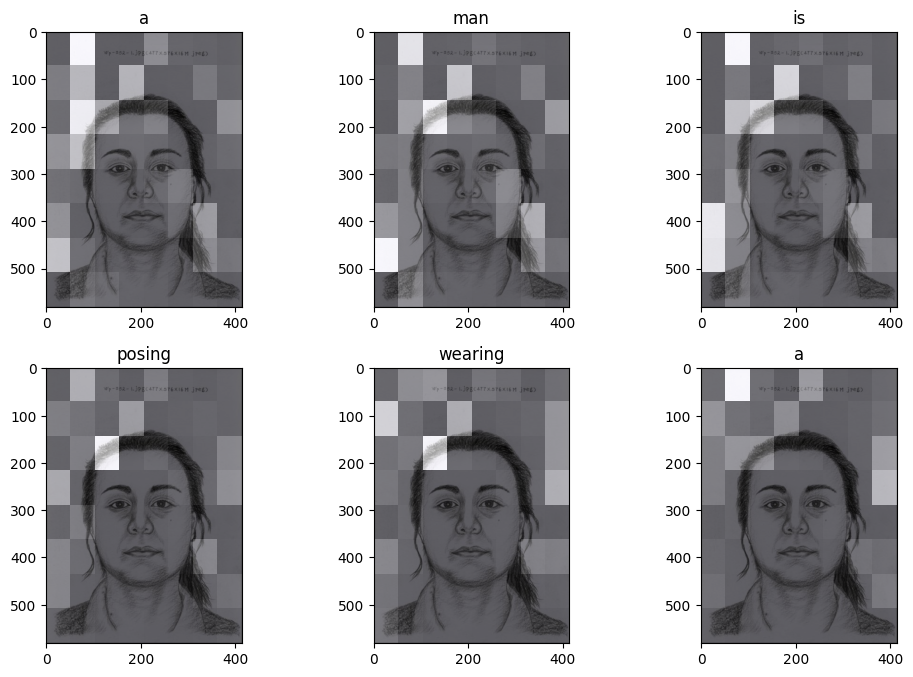

Prediction Caption: a couple of cows walking together


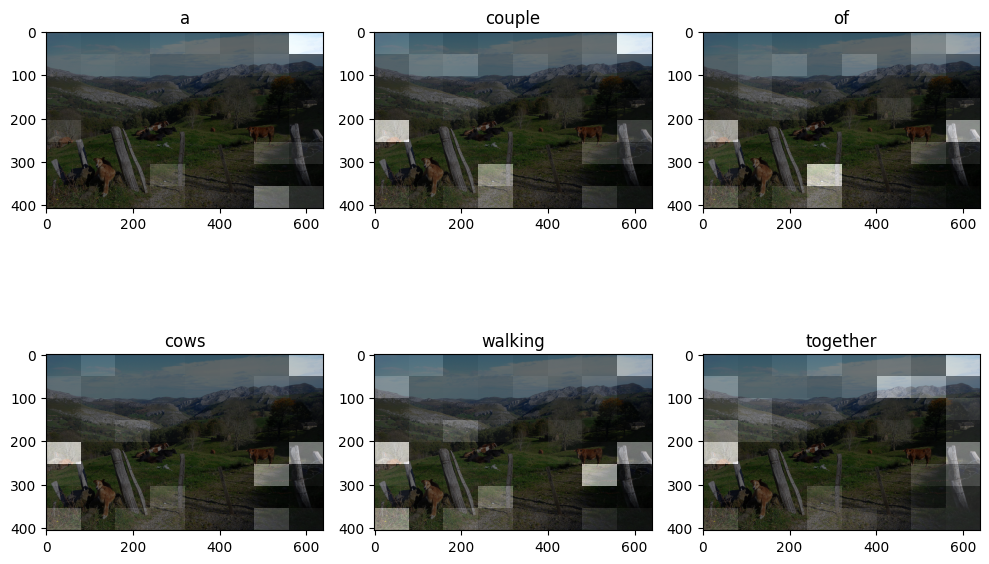

In [43]:
# tounum_path = 'data/1_data_cat_thomas/val/photo/'
tounum_path = 'data/0_data_unseen/data/'
tounum_images = os.listdir(tounum_path)

for image_path in tounum_images[:10]:
    result, attention_plot = evaluate(tounum_path + image_path)
    print('Prediction Caption:', ' '.join(result))
    plot_attention(tounum_path + image_path, result, attention_plot)
    # opening the image
    Image.open(tounum_path + image_path)

# ----------- Pipeline -----------

## Constants

In [44]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
BATCH_SIZE = 64

## Useful Functions

In [47]:
# Functions for image display (used below)

def display_imgs(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]).astype('uint8'), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def display_encoded_imgs(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def display_single_img(img, title):
    plt.figure(figsize=(20, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

## Load Data

In [49]:
# Load data from directory 
dataset = tf.keras.utils.image_dataset_from_directory('data/0_data_unseen/',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Convert BatchDataset to np array 
dataset = np.concatenate(list(dataset.map(lambda x, y: x))) 

Found 4 files belonging to 1 classes.


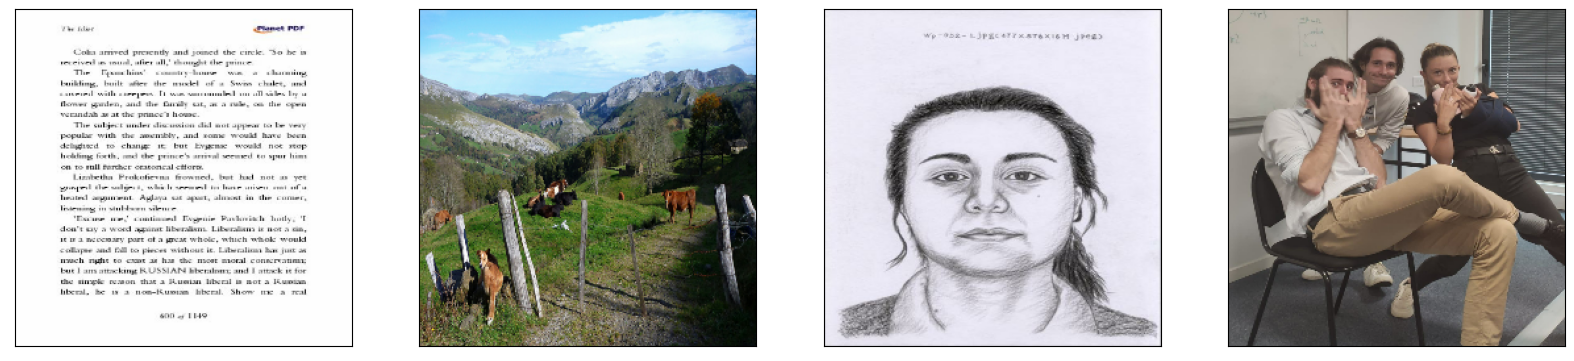

In [50]:
display_imgs(dataset, len(dataset))

# Binary Classifier (Deliverable 1)

In [51]:
# Import Classifier Model
bin_classifier_path = 'models/bin_10.20.2022_16:51:18_0.93%'
bin_classifier = tf.keras.models.load_model(bin_classifier_path)

In [52]:
# Use model to classify data
predictions = bin_classifier.predict(dataset)

# Save classified photos in a table
photos = []
for prediction, image in zip(predictions, dataset):
    # Prediction equal to 1 means photo
    if int(np.round(prediction)) == 1:
            photos.append(image)

1/1 [==============================] - 0s 285ms/step


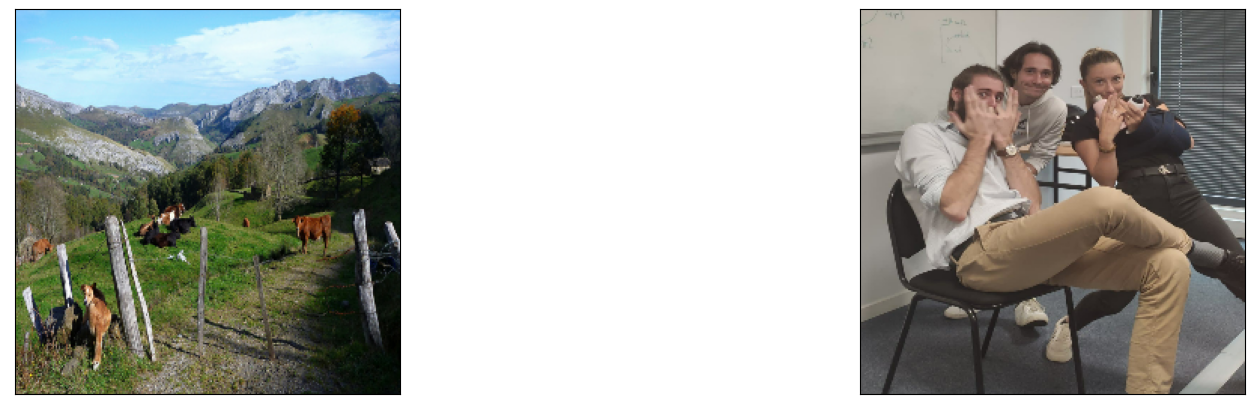

In [53]:
display_imgs(photos, len(photos))

# Denoising (Deliverable 2)

In [54]:
# Convert array photo to Dataset
photos = np.array(photos).astype('float32') / 255.
photos_dataset = tf.data.Dataset.from_tensor_slices(photos).batch(1)

In [55]:
# Define SSIM function for Denoiser model accuracy   
def ssim_accuracy(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

# Import Denoiser Model
denoiser_path = 'models/denoiser_10.20.2022_16:01:28'
denoiser = tf.keras.models.load_model(denoiser_path, custom_objects={"ssim_accuracy":ssim_accuracy})

In [56]:
# Use model to denoise photos
encoded_photos_dataset = denoiser.predict(photos_dataset)

2/2 [==============================] - 1s 4ms/step


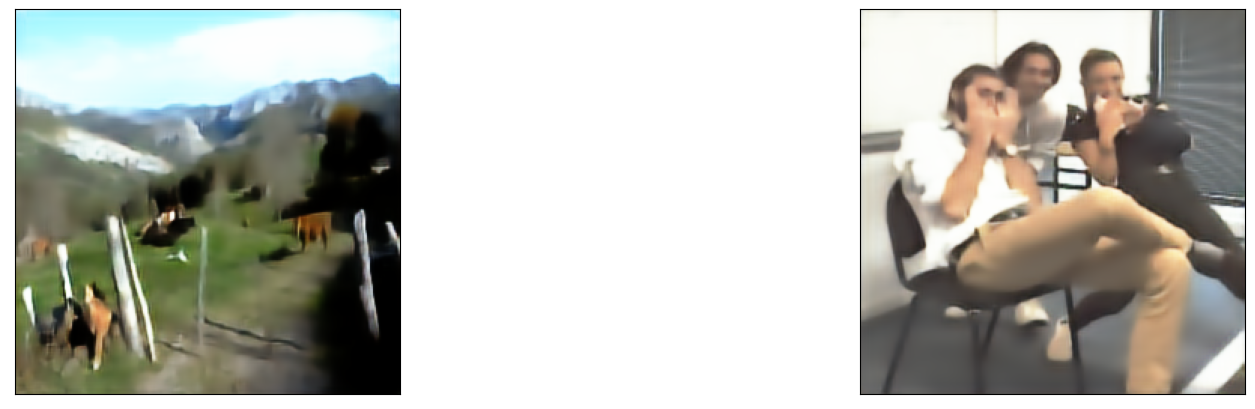

In [57]:
display_encoded_imgs(encoded_photos_dataset, len(encoded_photos_dataset))

# Captioning (Deliverable 3)

In [62]:
# Define function that create captions
def caption(image):
    max_length = 6
    attention_features_shape = 64

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(tf.convert_to_tensor(image), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tf.cast(word_to_index('<start>'),tf.int64)], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder.call(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.cast(tf.expand_dims([predicted_id], 0),tf.int64)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

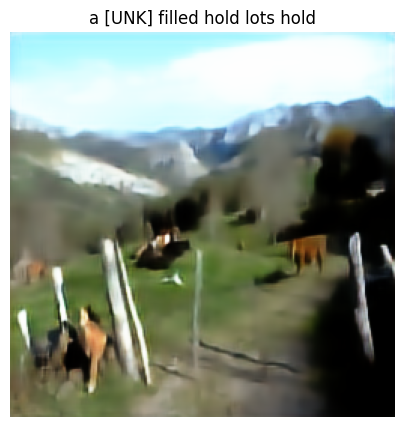

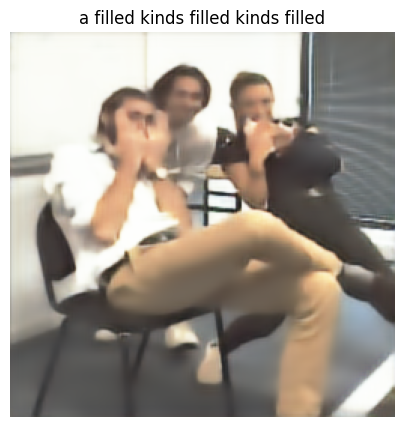

In [114]:
# Display photo and caption
for photo in encoded_photos_dataset:
    # Preprocess photo
    img = tf.convert_to_tensor(photo)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    # Use model to compute captions
    result = caption(img)
    # Display
    display_single_img(photo, ' '.join(result[0]))
